In [1]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torch.nn import functional as F
import time
from torchsummary import summary
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import confusion_matrix

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





In [23]:

class CocoSegmentationDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mask_transform=None):
        with open(annotations_file, 'r') as file:
            data = json.load(file)
        self.img_dir = img_dir
        self.transform = transform
        self.mask_transform = mask_transform if mask_transform else transform
        self.images = {image['id']: image for image in data['images']}
        self.annotations = data['annotations']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        image_info = self.images[image_id]
        image_path = os.path.join(self.img_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        
        mask = Image.new('L', (image_info['width'], image_info['height']), 0)
        draw = ImageDraw.Draw(mask)
        for polygon in annotation['segmentation']:
            draw.polygon(polygon, outline=1, fill=1)
        
        # Apply transformations to image and mask
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Apply a transformation to convert masks into tensors
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the mask as you do for the image
    transforms.ToTensor()
])

# Transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instances
train_dataset = CocoSegmentationDataset(
    annotations_file='../data/train/_annotations.coco.json',
    img_dir='../data/train/',
    transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = CocoSegmentationDataset(
    annotations_file='../data/valid/_annotations.coco.json',
    img_dir='../data/valid/',
    transform=image_transform,
    mask_transform=mask_transform
)

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Example: Iterate through train and validation loaders
for images, masks in train_loader:
    print('Train Batch:', images.shape, masks.shape)
    break

for images, masks in val_loader:
    print('Validation Batch:', images.shape, masks.shape)
    break


# Load the annotations file
annotations_file = '../data/train/_annotations.coco.json'  # Replace with the actual file path
with open(annotations_file, 'r') as file:
    data = json.load(file)

# Explore Image Metadata
print("Image Metadata:")
for image in data['images']:
    print(f"ID: {image['id']}, File Name: {image['file_name']}, Width: {image['width']}, Height: {image['height']}")

# Explore Annotations
print("\nAnnotations:")
for annotation in data['annotations']:
    print(f"Annotation ID: {annotation['id']}, Image ID: {annotation['image_id']}, Category ID: {annotation['category_id']}, Segmentation: {annotation['segmentation']}")

# Calculate Class Distribution
class_distribution = {}
for annotation in data['annotations']:
    category_id = annotation['category_id']
    if category_id in class_distribution:
        class_distribution[category_id] += 1
    else:
        class_distribution[category_id] = 1

# Print Class Distribution
print("\nClass Distribution:")
for category_id, count in class_distribution.items():
    print(f"Category ID: {category_id}, Count: {count}")

# Extract categories
categories = {category['id']: category['name'] for category in data['categories']}
for category_id, category_name in categories.items():
    print(f"ID: {category_id}, Name: {category_name}")


Train Batch: torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
Validation Batch: torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
Image Metadata:
ID: 0, File Name: 2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg, Width: 640, Height: 640
ID: 1, File Name: 2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg, Width: 640, Height: 640
ID: 2, File Name: 2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg, Width: 640, Height: 640
ID: 3, File Name: 2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg, Width: 640, Height: 640
ID: 4, File Name: 2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg, Width: 640, Height: 640
ID: 5, File Name: 2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg, Width: 640, Height: 640
ID: 6, File Name: 2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg, Width: 640, Height: 640
ID: 7, File Name: 1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg, Width: 640, Height: 640
ID: 8, File Name: 1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg, Width: 640, Height: 640
ID: 9

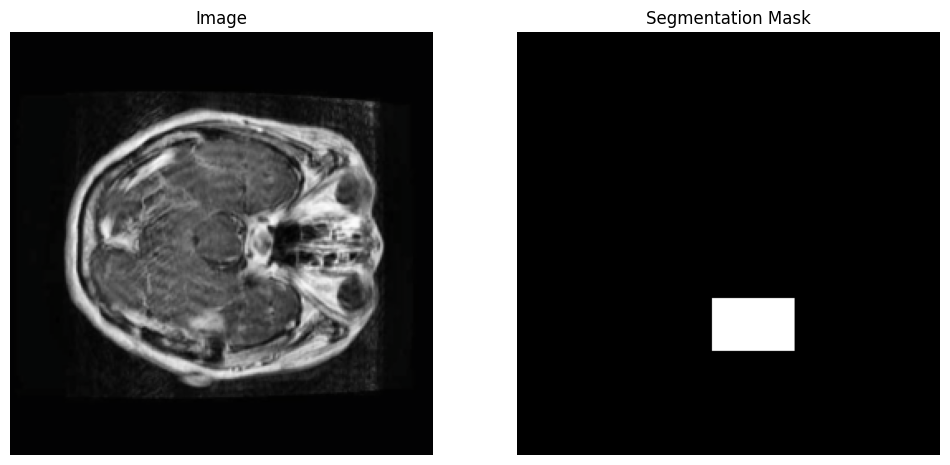

In [11]:
def show_image_and_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Assuming image normalization is reversed for visualization
    image = image.numpy().transpose((1, 2, 0))
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    image = np.clip(image, 0, 1)
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')

    # Mask is a single-channel grayscale image
    mask = mask.numpy().squeeze()
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Segmentation Mask')
    ax2.axis('off')

    plt.show()

# Testing with a single batch
for images, masks in train_loader:
    show_image_and_mask(images[0], masks[0])
    break  # Displaying only the first image and mask for checking

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.relu1(self.conv1(x))
        out = self.conv2(out)
        out += identity  # Element-wise addition (skip connection)
        out = self.relu2(out)
        return out

class ResNet_EncoderDecoder(nn.Module):
    def __init__(self, num_classes=1, in_chans=3):  # Set default in_chans to 3 for RGB images
        super(ResNet_EncoderDecoder, self).__init__()

        # Assuming the input images are RGB, in_chans should be 3.
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_chans, 32, kernel_size=3, padding=1)
        self.enc_block1 = ResidualBlock(32)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_block2 = ResidualBlock(64)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_block3 = ResidualBlock(128)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2)

        # Decoder layers
        self.dec_upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_block1 = ResidualBlock(64)

        self.dec_upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_block2 = ResidualBlock(32)

        self.dec_upconv3 = nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)  # Outputs num_classes channels

        # Not need since using BCEWithLogitLoss
        # self.dec_sigmoid = nn.Sigmoid()  # Use softmax if num_classes > 1

        # Print sizes of encoder and decoder feature maps
        self.debug = False

    def forward(self, x):
        # Encoder
        x = self.enc_conv1(x)
        if self.debug:
            print("Encoder conv1:", x.size())
        x = self.enc_block1(x)
        if self.debug:
            print("Encoder block1:", x.size())
        x = self.enc_pool1(x)
        if self.debug:
            print("Encoder pool1:", x.size())

        x = self.enc_conv2(x)
        if self.debug:
            print("Encoder conv2:", x.size())
        x = self.enc_block2(x)
        if self.debug:
            print("Encoder block2:", x.size())
        x = self.enc_pool2(x)
        if self.debug:
            print("Encoder pool2:", x.size())

        x = self.enc_conv3(x)
        if self.debug:
            print("Encoder conv3:", x.size())
        x = self.enc_block3(x)
        if self.debug:
            print("Encoder block3:", x.size())
        x = self.enc_pool3(x)
        if self.debug:
            print("Encoder pool3:", x.size())

        # Decoder
        x = self.dec_upconv1(x)
        if self.debug:
            print("Decoder upconv1:", x.size())
        x = self.dec_block1(x)
        if self.debug:
            print("Decoder block1:", x.size())

        x = self.dec_upconv2(x)
        if self.debug:
            print("Decoder upconv2:", x.size())
        x = self.dec_block2(x)
        if self.debug:
            print("Decoder block2:", x.size())

        x = self.dec_upconv3(x) # Outputs are logits, not passed through sigmoid
        if self.debug:
            print("Decoder upconv3:", x.size())


        return x




In [5]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    torch.autograd.set_detect_anomaly(True)

    # Define loss function
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model.to(device)
    summary(model, (3, 256, 256))
    
    
    train_loss_history = []
    valid_loss_history = []

    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad() # zero out the gradients
            outputs = model(images)
            #print(outputs.shape)
            loss = criterion(outputs, masks)

            loss.backward() # back propagate the loss
            optimizer.step()    # update the weights
            train_loss += loss.item() # add the loss to the train loss

            predicted = outputs > 0.5   # threshold the outputs to get the predicted masks
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                predicted = outputs > 0.5
                correct_valid += (predicted == masks).sum().item()
                total_valid += masks.numel()

                # all_vpreds.extend(predicted.view(-1).cpu().numpy())
                # all_vlabels.extend(masks.view(-1).cpu().numpy())

        valid_accuracy = correct_valid / total_valid

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train loss: {train_loss/len(train_loader):.4f}, "
               f"Train accuracy: {train_accuracy:.4f}, "
               f"Validation loss: {valid_loss/len(valid_loader):.4f}, "
               f"Validation accuracy: {valid_accuracy:.4f}")
        
        # Save the loss values for plotting
        train_loss_history.append(train_loss/len(train_loader))
        valid_loss_history.append(valid_loss/len(valid_loader))
        
    end_time = time.time()
    print(f"Time taken: {end_time-start_time:.2f}s")
    return model, train_loss_history, valid_loss_history


model = ResNet_EncoderDecoder()
model, train_loss_history, valid_loss_history = train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001)

# Save the model weights
torch.save(model.state_dict(), 'resnet_encoder_decoder.pth')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
            Conv2d-2         [-1, 32, 256, 256]           9,248
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
     ResidualBlock-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
            Conv2d-9         [-1, 64, 128, 128]          36,928
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
             ReLU-12         [-1, 64, 128, 128]               0
    ResidualBlock-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

Logits range: -18.661083 -7.181615


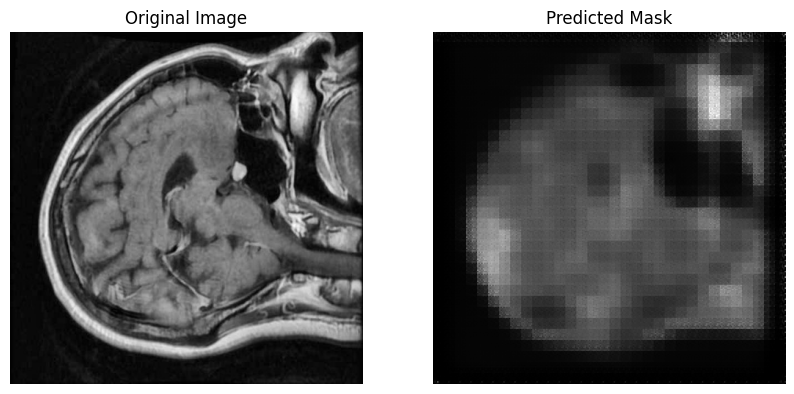

In [8]:
# Assume ResNet_EncoderDecoder and necessary imports are already defined above
model = ResNet_EncoderDecoder(num_classes=1)  # Adjust this if your model's architecture differs
model.load_state_dict(torch.load('resnet_encoder_decoder.pth'))
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the appropriate device




# Define transformation for inference
inference_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select an image from the test directory
test_image_dir = '../data/test/'
test_image_name = os.listdir(test_image_dir)[1]  # Grab the first image in the directory
test_image_path = os.path.join(test_image_dir, test_image_name)



# Modify the predict_image function to also return raw logits for inspection
def predict_image_with_logits(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move image to the appropriate device

    with torch.no_grad():
        logits = model(image)
        prediction = torch.sigmoid(logits)
        logits = logits.squeeze(0).cpu().numpy()  # Raw logits
        prediction = prediction.squeeze(0).cpu().numpy()

    return prediction, logits

# Obtain logits for more detailed analysis
predicted_mask, logits = predict_image_with_logits(model, test_image_path, inference_transform)
print("Logits range:", logits.min(), logits.max())  # Check the range of output values




# Ensure the mask is correctly squeezed to remove any singleton dimensions
predicted_mask = np.squeeze(predicted_mask)
"""
thresholds = [0.2, 0.5, 0.8]
fig, axes = plt.subplots(1, len(thresholds))
for i, thresh in enumerate(thresholds):
    axes[i].imshow(predicted_mask > thresh, cmap='gray')
    axes[i].set_title(f'Threshold: {thresh}')
    axes[i].axis('off')
plt.show()
"""

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(test_image_path))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

# plt.hist(logits.ravel(), bins=50)
# plt.title("Histogram of Logits")
# plt.show()



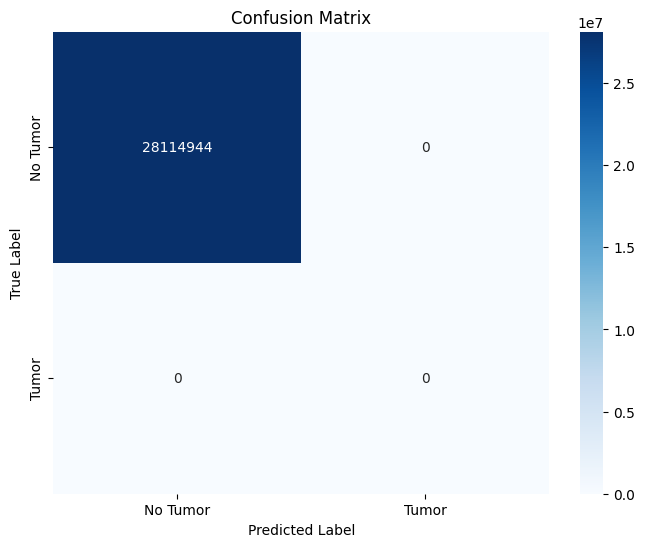

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix, classes):
    """
    This function plots a given confusion matrix.
    
    Parameters:
    - conf_matrix: numpy array, the confusion matrix to be plotted
    - classes: list of class names for the axis labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def incremental_conf_matrix(model, loader, device, classes):
    model.to(device)
    model.eval()
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Ensure binary predictions by thresholding and converting to integer
            predicted = (outputs > 0.5).float()
            preds = predicted.view(-1).cpu().numpy().astype(int)  # Ensure binary and convert to int
            actuals = masks.view(-1).cpu().numpy().astype(int)    # Ensure masks are also int

            # Incrementally update confusion matrix
            conf_matrix += confusion_matrix(actuals, preds, labels=classes)  # Use the provided classes directly
    return conf_matrix


# Assuming you have already defined model and val_loader
# Also, classes should be defined based on your specific segmentation task (e.g., [0, 1] for binary segmentation)

conf_matrix = incremental_conf_matrix(model, val_loader, device, classes=[0, 1])
plot_confusion_matrix(conf_matrix, classes=['No Tumor', 'Tumor'])
